# Clustering

In [14]:
import numpy as np
import random
import sklearn.preprocessing
import pandas as pd
import pyclustertend
movies_data = pd.read_csv("movies/movies.csv",encoding ='latin1')
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns

from sklearn.decomposition import PCA



## 1.1 Haga el preprocesamiento del dataset, explique qué variables no aportan información a la generación de grupos y por qué. Describa con qué variables calculará los grupos.

In [15]:
categorical_columns = [ # innecesarias para clustering
    "id", 
    "genres",
    "homePage", 
    "productionCompany",
    "productionCompanyCountry",
    "productionCountry", 
    "releaseDate",  
    "actors",      
    "director",
    "actorsPopularity",
    "actorsCharacter",
    "originalTitle",
    "title",
    "originalLanguage",
    "video"
]

df_clustering = movies_data.drop(columns=categorical_columns, errors='ignore')

# Convertir a numérico y eliminar filas con valores no convertibles
df_clustering["castWomenAmount"] = pd.to_numeric(df_clustering["castWomenAmount"], errors="coerce")
df_clustering["castMenAmount"] = pd.to_numeric(df_clustering["castMenAmount"], errors="coerce")

# Eliminar filas con valores nulos después de la conversión
df_clustering = df_clustering.dropna(subset=["castWomenAmount", "castMenAmount"])

# Verificar que ya no haya valores nulos en estas columnas
print(df_clustering["castWomenAmount"].isnull().sum())
print(df_clustering["castMenAmount"].isnull().sum())

print('variables para clustering')
print(df_clustering.columns)


0
0
variables para clustering
Index(['budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount',
       'genresAmount', 'productionCoAmount', 'productionCountriesAmount',
       'actorsAmount', 'castWomenAmount', 'castMenAmount'],
      dtype='object')


## 1.2 Analice la tendencia al agrupamiento usando el estadístico de Hopkings y la VAT (Visual Assessment of cluster Tendency). Esta última hágala si es posible, teniendo en cuenta las dimensiones del conjunto de datos. Discuta sus resultados e impresiones.

Estadística de Hopkins: 0.0208


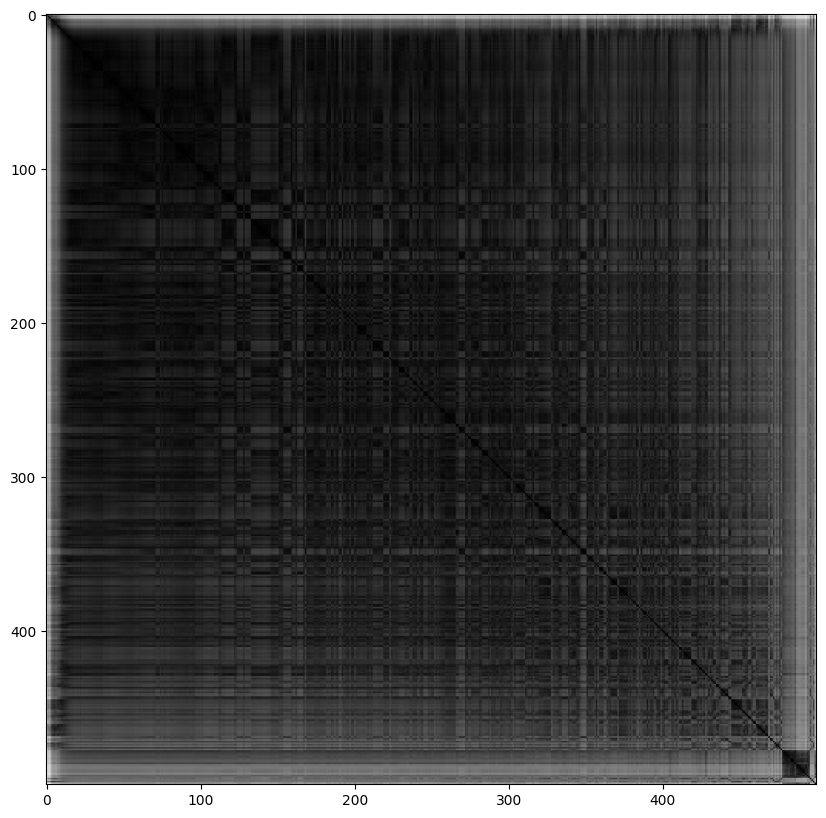

In [16]:
from sklearn.preprocessing import StandardScaler

# X = np.array(df_clustering[['budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount',
#                             'genresAmount', 'productionCoAmount', 'productionCountriesAmount',
#                             'actorsAmount', 'castWomenAmount', 'castMenAmount']])

X = np.array(df_clustering[['budget', 'revenue', 'popularity', 'voteAvg', 
                            'actorsAmount', 'castWomenAmount', 'castMenAmount']])


# Fijar la semilla para obtener resultados reproducibles
# random.seed(123)

# Escalar los datos para normalización
X_scale = sklearn.preprocessing.scale(X)

# Calcular la estadística de Hopkins
hopkins_stat = pyclustertend.hopkins(X_scale, len(X_scale))

# Imprimir resultado
print(f'Estadística de Hopkins: {hopkins_stat:.4f}')

X_scale = StandardScaler().fit_transform(X)
if X_scale.shape[0] > 500:
    X_sampled = X_scale[random.sample(range(X_scale.shape[0]), 500), :]
else:
    X_sampled = X_scale
pyclustertend.vat(X_sampled)


## 1.3 Determine cuál es el número de grupos a formar más adecuado para los datos que está trabajando. Haga una gráfica de codo y explique la razón de la elección de la cantidad de clústeres con la que trabajará.

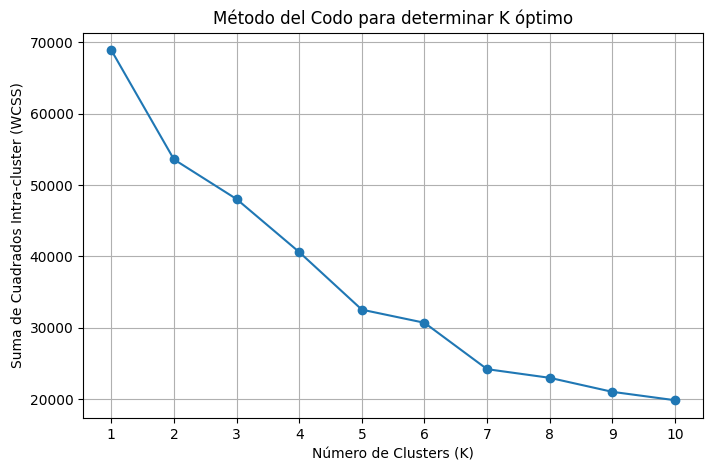

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

num_clusters = range(1, 11)
wcss = []  # Within-Cluster Sum of Squares (Inercia)

# Aplicar K-Means para cada número de clusters
for i in num_clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)  # Inercia: suma de las distancias intra-cluster

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(num_clusters, wcss, marker='o', linestyle='-')
plt.xticks(num_clusters)
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Suma de Cuadrados Intra-cluster (WCSS)")
plt.title("Método del Codo para determinar K óptimo")
plt.grid()
plt.show()


## 1.4 Utilice los algoritmos k-medias y clustering jerárquico para agrupar. Compare los resultados generados por cada uno.

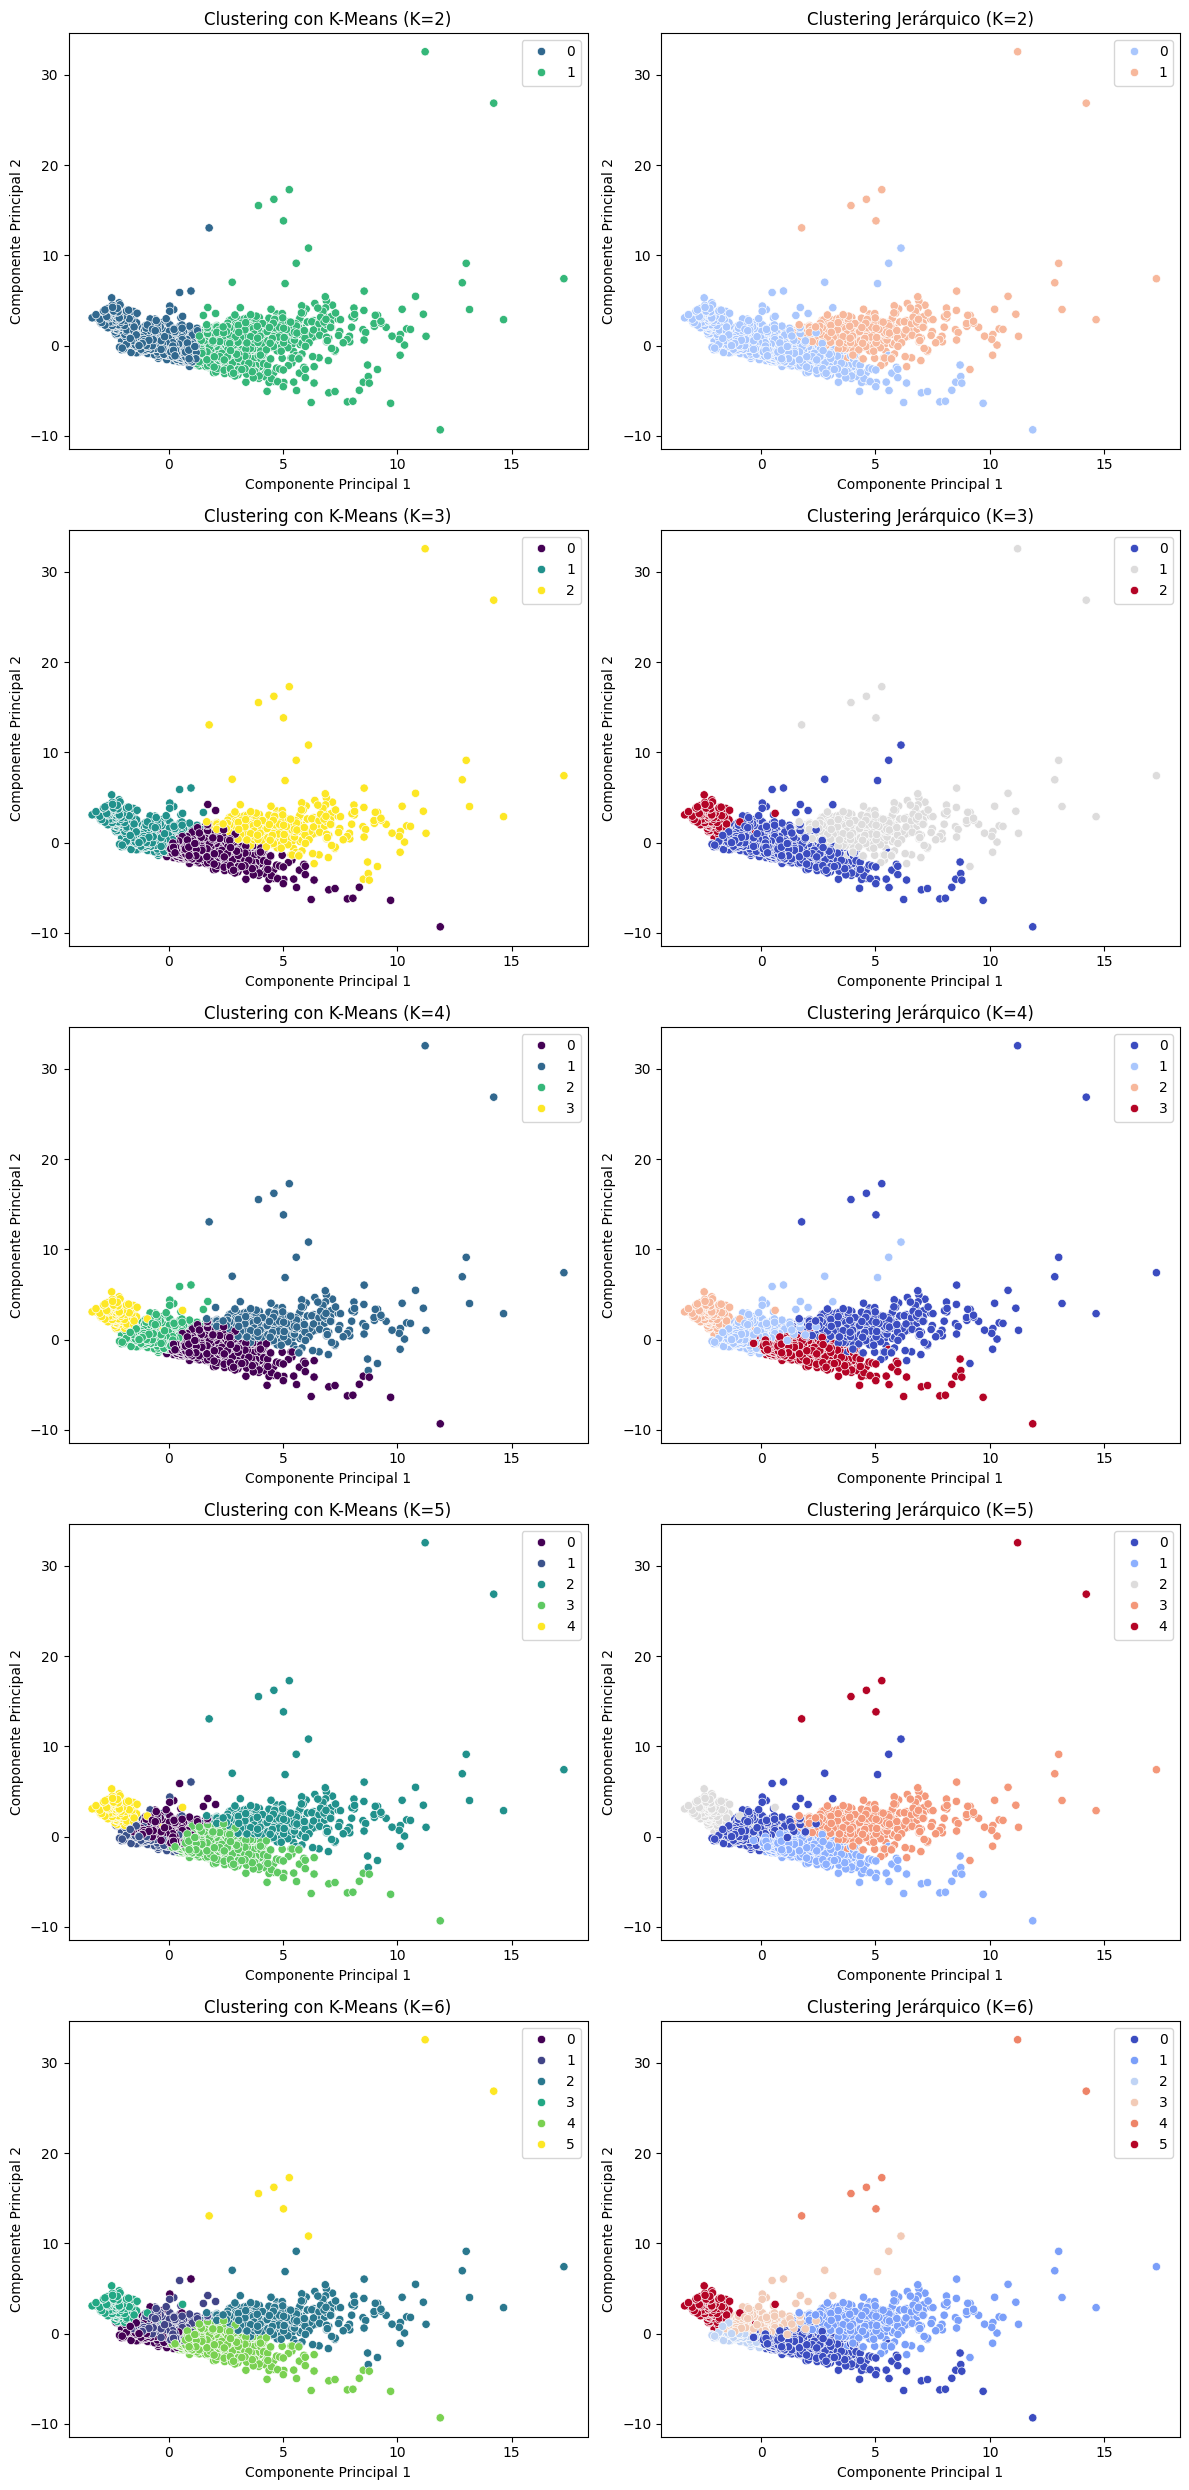

In [18]:


# Definir el rango de K a evaluar
k_values = range(2, 7)

# Escalar los datos para normalización
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Reducir la dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scale)

# Crear subplots para visualizar cada valor de K
fig, axes = plt.subplots(len(k_values), 2, figsize=(12, 5 * len(k_values)))

for idx, k in enumerate(k_values):
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k)
    clusters_kmeans = kmeans.fit_predict(X_scale)

    # Aplicar Clustering Jerárquico
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters_hierarchical = hierarchical.fit_predict(X_scale)

    # Graficar Clustering con K-Means
    sns.scatterplot(ax=axes[idx, 0], x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette="viridis", legend="full")
    axes[idx, 0].set_title(f"Clustering con K-Means (K={k})")
    axes[idx, 0].set_xlabel("Componente Principal 1")
    axes[idx, 0].set_ylabel("Componente Principal 2")

    # Graficar Clustering Jerárquico
    sns.scatterplot(ax=axes[idx, 1], x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_hierarchical, palette="coolwarm", legend="full")
    axes[idx, 1].set_title(f"Clustering Jerárquico (K={k})")
    axes[idx, 1].set_xlabel("Componente Principal 1")
    axes[idx, 1].set_ylabel("Componente Principal 2")

plt.tight_layout()
plt.show()




## 1.5 Determine la calidad del agrupamiento hecho por cada algoritmo con el método de la silueta. Discuta los resultados.

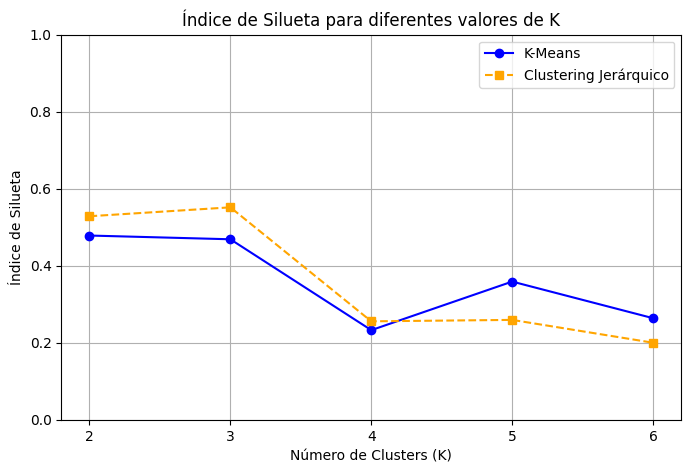

{2: (0.4783970717148317, 0.5285334403890404),
 3: (0.4686971444260607, 0.5516608364993296),
 4: (0.2326800779374831, 0.2555834535620564),
 5: (0.3587982726164297, 0.25927848094715333),
 6: (0.26369868149369585, 0.199974093984662)}

In [19]:
from sklearn.metrics import silhouette_score

# Definir el rango de K a evaluar
k_values = range(2, 7)

# Inicializar listas para almacenar los Silhouette Scores
silhouette_kmeans = []
silhouette_hierarchical = []

for k in k_values:
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=k)
    clusters_kmeans = kmeans.fit_predict(X_scale)
    
    # Aplicar Clustering Jerárquico
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    clusters_hierarchical = hierarchical.fit_predict(X_scale)

    # Calcular Silhouette Score y almacenar
    silhouette_kmeans.append(silhouette_score(X_scale, clusters_kmeans))
    silhouette_hierarchical.append(silhouette_score(X_scale, clusters_hierarchical))

# Graficar los resultados del Índice de Silueta para diferentes K
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_kmeans, marker='o', linestyle='-', label="K-Means", color="blue")
plt.plot(k_values, silhouette_hierarchical, marker='s', linestyle='--', label="Clustering Jerárquico", color="orange")
plt.xticks(k_values)
plt.ylim(0, 1)
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Índice de Silueta")
plt.title("Índice de Silueta para diferentes valores de K")
plt.legend()
plt.grid()
plt.show()

# Mostrar los valores numéricos
silhouette_results = dict(zip(k_values, zip(silhouette_kmeans, silhouette_hierarchical)))
silhouette_results


## 1.6 Interprete los grupos basado en el conocimiento que tiene de los datos. Recuerde investigar las medidas de tendencia central de las variables continuas y las tablas de frecuencia de las variables categóricas pertenecientes a cada grupo. Identifique hallazgos interesantes debido a las agrupaciones y describa para qué le podría servir

In [20]:
movies_data.describe()

,id,budget,revenue,runtime,popularity,voteAvg,voteCount,genresAmount,productionCoAmount,productionCountriesAmount,actorsAmount
count,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,249876.829300,1.855163e+07,5.673793e+07,100.268100,51.393907,6.483490,1342.381800,2.596500,3.171400,1.751000,2147.666600
std,257380.109004,3.662669e+07,1.495854e+08,27.777829,216.729552,0.984274,2564.196637,1.154565,2.539738,3.012093,37200.075802
min,5.000000,0.000000e+00,0.000000e+00,0.000000,4.258000,1.300000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,12286.500000,0.000000e+00,0.000000e+00,90.000000,14.577750,5.900000,120.000000,2.000000,2.000000,1.000000,13.000000
50%,152558.000000,5.000000e+05,1.631245e+05,100.000000,21.905500,6.500000,415.000000,3.000000,3.000000,1.000000,21.000000
75%,452021.750000,2.000000e+07,4.479661e+07,113.000000,40.654000,7.200000,1316.000000,3.000000,4.000000,2.000000,36.000000
max,922260.000000,3.800000e+08,2.847246e+09,750.000000,11474.647000,10.000000,30788.000000,16.000000,89.000000,155.000000,919590.000000
